### 필요한 모듈 import

In [1]:
#!pip install matplotlib
#!pip install pyupbit
#!pip install schedule
#!pip install sklearn
#!pip install tensorflow

In [2]:
import pyupbit
import schedule
import csv
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np

### 데이터 불러오기

In [25]:
#5년간의 30분봉 데이터(5,256,000개)
btc = pyupbit.get_ohlcv('KRW-BTC', count=2*60*24*365*5, interval='minute30') 
btc.to_csv('btc_30min.csv')

#메모리 문제로 500000개만 사용해봄
#btc = pyupbit.get_ohlcv('KRW-BTC', count=500000, interval='minute30') 
#btc.to_csv('btc_30min_500000.csv')

In [4]:
#추후 실시간으로 예측하는 모델 만든다면 실행할 함수
#def btc_update(): 
#    with open('btc_5min.csv', 'w') as data:
#        writer = csv.writer(data)
#        new_data = pyupbit.get_ohlcv('KRW-BTC', count=1, interval='minute5') 
#        writer.writerow(new_data)
            
#    now = datetime.datetime.now() 
#    print(f'현재시간 : {now}') 
        
#실행 주기 설정
#schedule.every(5).minutes.do(btc_update)

#스케줄러 시작
#while True: 
#    schedule.run_pending() 
#    time.sleep(1)

In [74]:
btc = pd.read_csv('btc_30min.csv')

btc

,Unnamed: 0,open,high,low,close,volume,value
0,2017-09-25 12:00:00,4201000.0,4244000.0,4191000.0,4221000.0,48.309792,2.038390e+08
1,2017-09-25 12:30:00,4219000.0,4242000.0,4199000.0,4202000.0,49.900614,2.104261e+08
2,2017-09-25 13:00:00,4222000.0,4235000.0,4208000.0,4235000.0,7.656490,3.230358e+07
3,2017-09-25 17:30:00,4235000.0,4235000.0,4235000.0,4235000.0,0.000030,1.270500e+02
4,2017-09-25 19:00:00,4213000.0,4213000.0,4213000.0,4213000.0,0.000021,8.649289e+01
...,...,...,...,...,...,...,...
82916,2022-06-23 07:30:00,26197000.0,26400000.0,26174000.0,26311000.0,86.387068,2.270550e+09
82917,2022-06-23 08:00:00,26311000.0,26358000.0,26269000.0,26294000.0,68.516116,1.802420e+09
82918,2022-06-23 08:30:00,26294000.0,26318000.0,26168000.0,26193000.0,91.673741,2.402613e+09
82919,2022-06-23 09:00:00,26180000.0,26750000.0,26105000.0,26586000.0,312.424101,8.249569e+09


In [75]:
scaler = Normalizer()

scaled = scaler.fit_transform(btc.iloc[:, 1:])

df = pd.DataFrame(scaled, columns=btc.columns[1:])

df

,open,high,low,close,volume,value
0,0.020592,0.020803,0.020543,0.020690,2.367974e-07,0.999146
1,0.020034,0.020143,0.019939,0.019953,2.369507e-07,0.999198
2,0.126443,0.126833,0.126024,0.126833,2.293016e-07,0.967449
3,0.500000,0.500000,0.500000,0.500000,3.541913e-12,0.000015
4,0.500000,0.500000,0.500000,0.500000,2.436506e-12,0.000010
...,...,...,...,...,...,...
82916,0.011535,0.011624,0.011525,0.011585,3.803658e-08,0.999732
82917,0.014591,0.014617,0.014568,0.014582,3.799722e-08,0.999574
82918,0.010941,0.010951,0.010889,0.010899,3.814675e-08,0.999761
82919,0.003173,0.003243,0.003164,0.003223,3.787079e-08,0.999980


In [76]:
features = ['open', 'high', 'low', 'volume', 'value']
target = ['close']

x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((66336, 5), (16585, 5), (66336, 1), (16585, 1))

In [77]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [78]:
WINDOW_SIZE = 50    #과거 50개의 데이터를 통해 예측
BATCH_SIZE = len(x)

train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [79]:
model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation="relu", input_shape=[WINDOW_SIZE, 5]),
    LSTM(64, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
model.compile(loss='huber', optimizer='adam', metrics=['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 46, 32)            832       
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,721
Trainable params: 26,721
Non-trainable params: 0
_________________________________________________________________


In [10]:
#param_grid = dict(batch_size=[32, 64, 128],
#                  optimizer=['Adam', 'SGD', 'RMSprop'],
#                  learning_rate=[0.01, 0.05, 0.1],
#                  actvation=['relu', 'softmax'])

#grid = GridSearchCV(scoring='neg_mean_squared_error',
#                    estimator=model, 
#                    param_grid=param_grid, 
#                    n_jobs=8)

#grid_result = grid.fit(x_train, y_train) 
'''TypeError: Cannot clone object '<keras.engine.sequential.
Sequential object at 0x00000212F4DCF1C0>' 
(type <class 'keras.engine.sequential.Sequential'>): 
it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.'''

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x0000024E7018FA60>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [80]:
# 30번 epoch동안 val_loss의 개선이 없다면 학습을 멈춤
earlystopping = EarlyStopping(monitor='val_loss', patience=30)

# val_loss 기준 체크포인터 생성
filename = os.path.join('tmp', 'ckeckpointer.ckpt')

checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=2)
                             
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
      1/Unknown - 14s 14s/step - loss: 0.0040 - mse: 0.0080
Epoch 1: val_loss improved from inf to 0.00105, saving model to tmp\ckeckpointer.ckpt
1/1 [==============================] - 16s 16s/step - loss: 0.0040 - mse: 0.0080 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0084
Epoch 2: val_loss improved from 0.00105 to 0.00043, saving model to tmp\ckeckpointer.ckpt
1/1 [==============================] - 14s 14s/step - loss: 0.0042 - mse: 0.0084 - val_loss: 4.3251e-04 - val_mse: 8.6502e-04
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0066
Epoch 3: val_loss improved from 0.00043 to 0.00015, saving model to tmp\ckeckpointer.ckpt
1/1 [==============================] - 14s 14s/step - loss: 0.0033 - mse: 0.0066 - val_loss: 1.5298e-04 - val_mse: 3.0596e-04
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0058
Epoch 4: val_loss did not im

In [86]:
loss = round(float(min(history.history['val_loss'])), 4)
print(f'val_loss = {loss}')

val_loss = 0.0001


In [87]:
model.load_weights(filename)

pred = model.predict(test_data)

actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))

print(pred.shape)
print(actual.shape)

(16535, 1)
(16535, 1)


In [88]:
model.evaluate(test_data, batch_size=128)

1/1 [==============================] - 2s 2s/step - loss: 1.0306e-04 - mse: 2.0612e-04


[0.00010306244803359732, 0.00020612489606719464]

In [89]:
#정규화된 close 실제값, 예측값을 정규화 전으로 돌리기 위해 비율 계산 
percent = btc.iloc[0,3] / df.iloc[0,3]
percent

202563197.8710924

In [90]:
y_test.values

array([[0.0049496 ],
       [0.00963539],
       [0.00853521],
       ...,
       [0.01089928],
       [0.00322265],
       [0.01247268]])

In [91]:
pred

array([[0.01165207],
       [0.01093987],
       [0.01087931],
       ...,
       [0.01244238],
       [0.01251374],
       [0.01206164]], dtype=float32)

In [92]:
actual = y_test.values * percent
pred *= percent

In [93]:
actual

array([[1002606.44652464],
       [1951774.70354916],
       [1728920.44277301],
       ...,
       [2207793.24092054],
       [ 652789.84799804],
       [2526505.43706408]])

In [94]:
pred

array([[2360281.2],
       [2216015.5],
       [2203748.5],
       ...,
       [2520368. ],
       [2534824. ],
       [2443244.2]], dtype=float32)

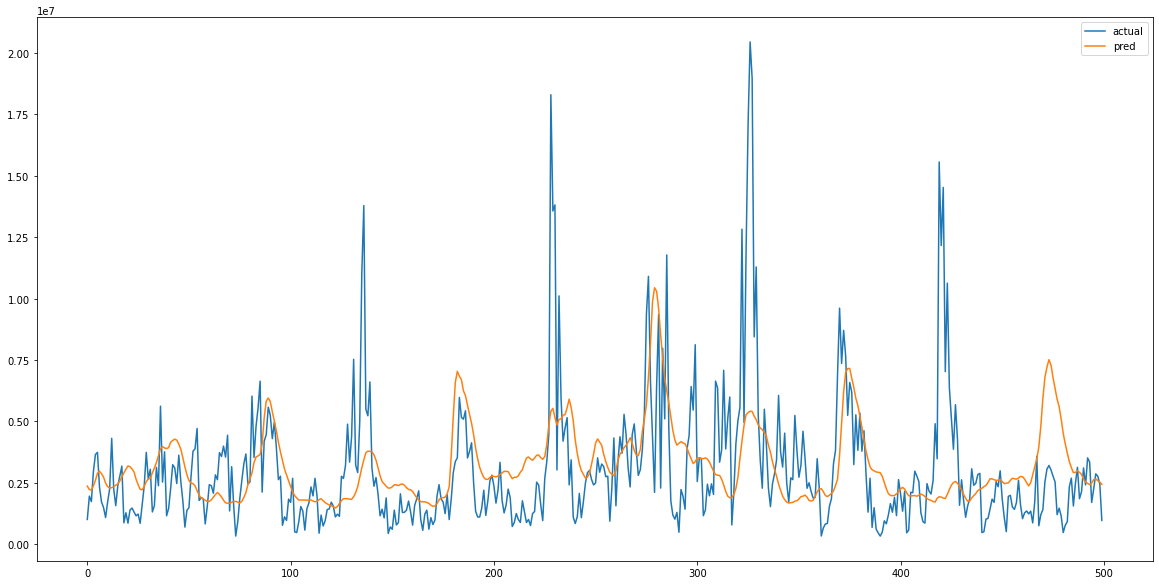

In [98]:
plt.figure(figsize=(20,10))
plt.plot(actual[:500], label='actual')
plt.plot(pred[:500], label='pred')
plt.legend()
plt.show()

In [116]:
len(pred)

16535

In [119]:
#30분 뒤 가격 예측
seed_money = 1000000

origin_percent = (float(btc['close'][len(btc['close'])-1]) - float(btc['close'][WINDOW_SIZE])) / float(btc['close'][WINDOW_SIZE]) * 100
array_pred_percents = []

for idx in range(len(pred)):
    live_close = float(btc['close'][idx+WINDOW_SIZE])
    pred_close = float(pred[idx])
    pred_percent = (pred_close - live_close) / live_close * 100
    if pred_percent > 0:
        array_pred_percents.append(pred_percent)

    if idx%1000==0:
        print("%d 현재가 %d ---> 30분 후 예상 가격%d" % (idx, live_close, pred_close), end='')
        print(" ===> 예상 수익률 %.2f%%" % (pred_percent), end=', ')
    
        if idx + WINDOW_SIZE + 1 < len(df['close']):
            live_percent = (float(btc['close'][idx+WINDOW_SIZE+1]) - live_close) / live_close * 100
        
            print("실제 수익률 %.2f%%  " % (live_percent))
        
        else:
            print()
        
#        
print("\n30분 후 예상 수익률 : %.2f%%" % (pred_percent))

0 현재가 4359000 ---> 30분 후 예상 가격2360281 ===> 예상 수익률 -45.85%, 실제 수익률 0.09%  
1000 현재가 6402000 ---> 30분 후 예상 가격3946780 ===> 예상 수익률 -38.35%, 실제 수익률 -0.36%  
2000 현재가 8113000 ---> 30분 후 예상 가격2403880 ===> 예상 수익률 -70.37%, 실제 수익률 0.21%  
3000 현재가 11521000 ---> 30분 후 예상 가격1707575 ===> 예상 수익률 -85.18%, 실제 수익률 1.94%  
4000 현재가 22233000 ---> 30분 후 예상 가격2574234 ===> 예상 수익률 -88.42%, 실제 수익률 0.48%  
5000 현재가 23185000 ---> 30분 후 예상 가격1667315 ===> 예상 수익률 -92.81%, 실제 수익률 1.10%  
6000 현재가 12680000 ---> 30분 후 예상 가격2195122 ===> 예상 수익률 -82.69%, 실제 수익률 -1.22%  
7000 현재가 13000000 ---> 30분 후 예상 가격1580354 ===> 예상 수익률 -87.84%, 실제 수익률 -0.42%  
8000 현재가 10224000 ---> 30분 후 예상 가격4766311 ===> 예상 수익률 -53.38%, 실제 수익률 -0.59%  
9000 현재가 7619000 ---> 30분 후 예상 가격8140705 ===> 예상 수익률 6.85%, 실제 수익률 0.00%  
10000 현재가 9696000 ---> 30분 후 예상 가격3771696 ===> 예상 수익률 -61.10%, 실제 수익률 0.22%  
11000 현재가 9515000 ---> 30분 후 예상 가격1891158 ===> 예상 수익률 -80.12%, 실제 수익률 0.28%  
12000 현재가 8357000 ---> 30분 후 예상 가격2891999 ===> 예상 수익률 -65.39%, 실제 수익률